In [117]:
from igraph import Graph
import pandas as pd
import igraph
import networkx as nx

In [2]:
nodes=pd.read_csv('Nodes_df4.csv')
edges=pd.read_csv('Edges_df4.csv')

#### Individuiamo il Giant Component

In [3]:
g_nx=nx.from_pandas_edgelist(edges,source='Source',target='Target')
component_subgraph_list = list(nx.connected_components(g_nx))
largest_component = list(max(component_subgraph_list,key=len))


In [4]:
nodes_list=list(nodes.Id)
new_edges=edges[(edges['Source'].isin(largest_component)) & (edges['Target'].isin(largest_component))]
new_g=Graph.DataFrame(edges=new_edges[['Source','Target']],directed=True)

In [ ]:
#codice per identificare giant component
nodes['Giant_Component']=0

colour=[]
for index in largest_component:
    subset=nodes[nodes.Id==index]
    if subset.empty == False:
        sub_index=subset.index
        nodes.at[sub_index,'Giant_Component']=1
    else:
        continue

#### Applichiamo leading eigenvector

In [5]:
eigen=new_g.community_leading_eigenvector(2)
eigen.summary()

C:\Users\Eric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\igraph\__init__.py:1281: RuntimeWarning: This method was developed for undirected graphs at src/community/leading_eigenvector.c:530
  membership, _, q = GraphBase.community_leading_eigenvector(


'Clustering with 3527 elements and 2 clusters'

In [6]:
eigen_nodes=eigen.graph.vs["name"]
df_eigen=pd.DataFrame({'nodes':eigen_nodes,'clusters':eigen._membership})

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

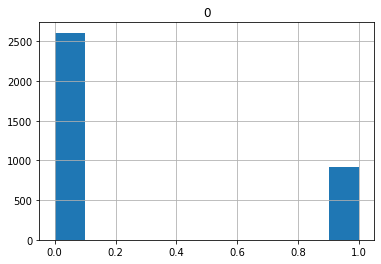

In [7]:
pd.DataFrame(eigen._membership).hist()

In [ ]:
def color_clusters(cluster_df,cluster_field,new_cluster_field_name):
    clusters=list(set(cluster_df[cluster_field]))
    nodes[new_cluster_field_name]=0

    for index, row in cluster_df.iterrows():
        subset=nodes[nodes.Id==int(row['nodes'])]
        if subset.empty == False:
            sub_index=subset.index
            for cluster in clusters:
                if row['clusters']==cluster:
                    nodes.at[sub_index,new_cluster_field_name]=cluster+1
        else:
            continue

In [ ]:
color_clusters(df_eigen,'clusters','Cluster_eigen')

In [8]:
#clusters=list(set(df_eigen.clusters))
#nodes['Cluster_eigen']=0
#
#colour=[]
#for index, row in df_eigen.iterrows():
#    subset=nodes[nodes.Id==int(row['nodes'])]
#    if subset.empty == False:
#        sub_index=subset.index
#        for cluster in clusters:
#            if row['clusters']==cluster:
#                nodes.at[sub_index,'Cluster_eigen']=cluster+1
#    else:
#        continue

In [9]:
#utile solo nel caso che il dataframe di partenza presenti gli hex colors invece dei cluster

#for i,r in nodes.iterrows():
#    if r['Colour']=='#aaaacc':
#        nodes.at[i,'Colour']=0
#    if r['Colour']=='#007474':
#        nodes.at[i,'Colour']=1
#    if r['Colour']=='#fb1239':
#        nodes.at[i,'Colour']=2

#### Creazione indice e applicazione k-means

In [124]:
contiguous_nodes_dict={}

for node in nodes.Id:
    lista_target=list(new_edges[new_edges.Source==node]['Target'])
    lista_source=list(new_edges[new_edges.Target==node]['Source'])
    lista_tot=lista_target+lista_source
    if lista_tot != []:
        contiguous_nodes_dict[node]=lista_tot

In [125]:
def Jaccard(nodesA,nodesB):
    intersect = [value for value in nodesA if value in nodesB]
    union=list(set(nodesA+nodesB))
    compute_jaccard=len(intersect)/len(union)
    return compute_jaccard

In [126]:
distance_matrix_j=[[ Jaccard(values_col,values_row) for values_row in contiguous_nodes_dict.values()] for values_col in contiguous_nodes_dict.values()]

In [127]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0,n_init=100,max_iter=1000,algorithm="elkan").fit(distance_matrix_j)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

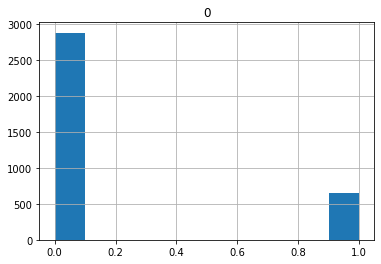

In [128]:
pd.DataFrame(kmeans.labels_).hist()

In [377]:
df_means=pd.DataFrame({'nodes':contiguous_nodes_dict.keys(),'clusters':kmeans.labels_})

In [ ]:
color_clusters(df_means,'clusters','Cluster_kmeans')

In [378]:
#nodes['Colour']='#aaaacc'
#
#colour=[]
#for index, row in df_means.iterrows():
#    subset=nodes[nodes.Id==int(row['nodes'])]
#    if subset.empty == False:
#        sub_index=subset.index
#        if row['clusters']==0:
#            nodes.at[sub_index,'Colour']='1'
#        if row['clusters']==1:
#            nodes.at[sub_index,'Colour']='2'
#    else:
#        continue

#### Modularity maximization

In [130]:
new_G = nx.from_edgelist([(names[x[0]], names[x[1]])
                      for names in [new_g.vs['name']] # simply a let
                      for x in new_g.get_edgelist()], nx.DiGraph())

In [131]:
new_G=new_G.to_undirected()

In [132]:
from networkx.algorithms.community import modularity_max
c = list(modularity_max.greedy_modularity_communities(new_G))

In [456]:
nodes['Cluster_mod']='#aaaacc'

colours_list=list(range(0,24))
i=0
for community in c:
    colour=[]
    for node in list(community):
        subset=nodes[nodes.Id==int(node)]
        if subset.empty == False:
            sub_index=subset.index
            nodes.at[sub_index,'Cluster_mod']=colours_list[i]
        else:
            continue
    i+=1

#### Girvan-Newman

In [414]:
new_G = nx.from_edgelist([(names[x[0]], names[x[1]])
                      for names in [new_g.vs['name']] # simply a let
                      for x in new_g.get_edgelist()], nx.DiGraph())

In [415]:
new_G=new_G.to_undirected()

In [397]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

In [398]:
def girvan_newman(graph):
	# find number of connected components
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

In [416]:
# find communities in the graph
c = girvan_newman(new_G.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
  node_groups.append(list(i))

In [417]:
nodes['Colour_GN']=0

for group in range(0,len(node_groups)):
    for idx in node_groups[group]:
        subset=nodes[nodes.Id==int(idx)]
        if subset.empty == False:
            sub_index=subset.index
            nodes.at[sub_index,'Colour_GN']=group+1
        else:
            continue

In [418]:
nodes.to_csv('Nodes_df4_cluster.csv',index=False)